# 1. Pre-processing

#### 1.1. Text Pre-processing

The dataset is already lowercased and lacks punctuation. We will tokenize the text and remove stopwords, as well as apply lemmatization to the tokens.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

data = pd.read_json('./data/data.jsonl', lines=True)
def pre_process_data(dataset):
    #tokenize
    dataset['text'] = dataset['text'].apply(nltk.word_tokenize)

    #remove stop words
    stop_words = set(stopwords.words('english'))
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in stop_words])

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    dataset['text'] = dataset['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    return dataset

data = pre_process_data(data)
data.head()

C:\Users\fabio\AppData\Local\Temp\ipykernel_11576\3172380938.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,"[feel, awful, job, get, position, succeed, hap...",0
1,"[im, alone, feel, awful]",0
2,"[ive, probably, mentioned, really, feel, proud...",1
3,"[feeling, little, low, day, back]",0
4,"[beleive, much, sensitive, people, feeling, te...",2


In [45]:
test_data = pd.read_json('./data/test.jsonl', lines=True)
train_data = pd.read_json('./data/train.jsonl', lines=True)
validation_data = pd.read_json('./data/validation.jsonl', lines=True)

test_data = pre_process_data(test_data)
train_data = pre_process_data(train_data)
validation_data = pre_process_data(validation_data)

print(test_data["text"])

0       [im, feeling, rather, rotten, im, ambitious, r...
1                      [im, updating, blog, feel, shitty]
2       [never, make, separate, ever, want, feel, like...
3       [left, bouquet, red, yellow, tulip, arm, feeli...
4                            [feeling, little, vain, one]
                              ...                        
1995    [keep, feeling, like, someone, unkind, wrong, ...
1996    [im, feeling, little, cranky, negative, doctor...
1997    [feel, useful, people, give, great, feeling, a...
1998    [im, feeling, comfortable, derby, feel, though...
1999    [feel, weird, meet, w, people, text, like, don...
Name: text, Length: 2000, dtype: object


# 2. Vectorization
(secção possívelmente temporária, mas queria experimentar as cenas de tf_idf depois do pré-processamento) -- matos
não acho que convenha ser temporaria, dado que efetivamente melhora os resultados ihihihi, e é uma prática comum e recomendada pelo que estivemos a ver -- ines


### TF-IDF

#### Hypertunning for tf-idf

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfVectorizer(data, train_data, validation_data, test_data):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=40000)
    # good idea to use two-grams??
    # print(X.shape)

    x_train = vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']
    
    # print(vectorizer.get_feature_names_out())

    return x_train, x_val, x_test, y_train, y_val, y_test



### BOW model
Count vectorizer which is an implementation of the BOW model.

The disadvantage of the BOW model is it does not consider the sequence of words, and as language does involve sequence and context, sometimes the BOW model might not be a good fit for the best-case scenario.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def countVectorizer(data, train_data, validation_data, test_data):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=40000)

    x_train= vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Doc 2 Vec

#### Document 2 Vector training

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils

def train_doc2vec(train_data):
    max_epochs = 100
    vec_size = 20
    alpha = 0.025

    tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]

    model = Doc2Vec(vector_size=vec_size,
                    alpha=alpha,
                    min_alpha=0.00025,
                    min_count=1,
                    dm=1)
    
    model.build_vocab(tagged_data)

    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    print(model.epochs)
    model.save("d2v.model")
    print("Model Saved")

    return model

#train_doc2vec(train_data)

In [41]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from gensim.models.doc2vec import Doc2Vec

def doc2vec(data, train_data, validation_data, test_data):

    # training the doc2vec model
    #model = train_doc2vec(train_data)
    model = Doc2Vec.load("d2v2.model")
    
    x_train = [model.infer_vector(doc) for doc in train_data['text']]
    x_val = [model.infer_vector(doc) for doc in validation_data['text']]
    x_test = [model.infer_vector(doc) for doc in test_data['text']]

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

### Word 2 Vec

In [20]:
from gensim.models import Word2Vec
import numpy as np

def lala(model, data):
    vectors = []
    for doc in data['text']:
        document = []
        for word in doc:
            if word in model.wv:
                document.append(model.wv[word])
        vectors.append(document)
    return vectors

# test [d,c,c]  | label
########################
## test 
## [ [] [] [] ] | label

def wordEmbeddingsVectorizer(data):

    data_model = Word2Vec(data["text"], vector_size=3, window=10, min_count=2, workers=10, sg=1)
    
    x_train = lala(data_model, train_data)
    x_val =lala(data_model, validation_data)
    x_test = lala(data_model, test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



In [46]:
# Choose vectorizer (featurizer)
#x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer(data)
x_train, x_val, x_test, y_train, y_val, y_test = doc2vec(data, train_data, validation_data, test_data)

#print(x_train)
#! SAME BED BUT IT FEELS JUSt A LITTLE BIT BIGGER NOW
#! SAME SONG ON THE RADIO BUT IT DON'T SOUND THE SAME
#! WHEN OUR FRIENDS TALK ABOUT YOU ALL IT DOES IS JUST TEAR ME DOWN
#! CAUSE MY HEART BREAKS A LITTLE WHEN I HEAR YOUR NAME
#! IT ALL JUST SOUNDS LIKE
#! OOOH
#! Mmm
#! TOO YOUNG TOO DUMB TO REALIZE
#! THAT I SHOULD HAVE BOUGHT YOU FLOWERS
#! AND HELD YOUR HAND
#! SHOULD HAVE GAVE YOU ALL MY HOURS
#! WHEN I HAD THE CHANCE
## Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=10)
x_train, y_train = smote.fit_resample(x_train, y_train)



# 3. Model Training

#### 3.1. Model Selection
Aqui também só estava a querer espetar modelos para começar a ver o que dá que ainda não sei que features vão ser usadas:
tf-idf, word embeddings, ???, features mais feitas à mão?


Isto pelos vistos é uma cena, que não implementei (ainda..)

"The validation set uses a subset of the training data to provide an unbiased evaluation of a model. The validation data set contrasts with training and test sets in that it is an intermediate phase used for choosing the best model and optimizing it. It is in this phase that hyperparameter tuning occurs."

Wikipedia:
The basic process of using a validation data set for model selection (as part of training data set, validation data set, and test data set) is:

Since our goal is to find the network having the best performance on new data, the simplest approach to the comparison of different networks is to evaluate the error function using data which is independent of that used for training. Various networks are trained by minimization of an appropriate error function defined with respect to a training data set. The performance of the networks is then compared by evaluating the error function using an independent validation set, and the network having the smallest error with respect to the validation set is selected. This approach is called the hold out method. Since this procedure can itself lead to some overfitting to the validation set, the performance of the selected network should be confirmed by measuring its performance on a third independent set of data called a test set.

An application of this process is in early stopping, where the candidate models are successive iterations of the same network, and training stops when the error on the validation set grows, choosing the previous model (the one with minimum error).

##### 3.1.1. Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logreg_classifier = LogisticRegression(max_iter=1000)
logreg_classifier.fit(x_train, y_train)
y_pred = logreg_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.826
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       550
           1       0.90      0.86      0.88       704
           2       0.73      0.76      0.75       178
           3       0.81      0.80      0.80       275
           4       0.71      0.74      0.72       212
           5       0.64      0.78      0.70        81

    accuracy                           0.83      2000
   macro avg       0.77      0.80      0.79      2000
weighted avg       0.83      0.83      0.83      2000

[[476  19   6  22  23   4]
 [ 32 602  39   9  14   8]
 [ 10  21 136   6   3   2]
 [ 20  13   4 219  15   4]
 [ 15   8   1  14 156  18]
 [  5   4   0   1   8  63]]


##### 3.1.2. Multinomial Naive Bayes

In [23]:
'''
mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_train, y_train)
y_pred = mnb_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
'''


'\nmnb_classifier = MultinomialNB()\nmnb_classifier.fit(x_train, y_train)\ny_pred = mnb_classifier.predict(x_val)\nprint(accuracy_score(y_val, y_pred))\nprint(classification_report(y_val, y_pred))\nprint(confusion_matrix(y_val, y_pred))\n'

# RF


In [49]:
# random forest

from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


KeyboardInterrupt: 

## SVM


In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.687
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.75       550
           1       0.85      0.71      0.77       704
           2       0.51      0.57      0.54       178
           3       0.64      0.67      0.65       275
           4       0.53      0.62      0.58       212
           5       0.36      0.53      0.43        81

    accuracy                           0.69      2000
   macro avg       0.61      0.64      0.62      2000
weighted avg       0.71      0.69      0.69      2000

Confusion Matrix:
 [[415  23  15  42  40  15]
 [ 64 498  56  30  32  24]
 [ 16  28 102   8  13  11]
 [ 29  16  13 184  23  10]
 [ 25  12   9  17 132  17]
 [ 11  10   4   6   7  43]]


### Boosting Algorithms

Testing with some boosting algorithms

##### XGBOOST

In [25]:
import xgboost as xgb
# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train, y_train)
y_pred_xgb = xgb_classifier.predict(x_val)

# Evaluate the performance for XGBoost
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
report_xgb = classification_report(y_val, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

# Print the evaluation metrics for XGBoost
print("XGBoost Classifier Evaluation:")
print("Accuracy:", accuracy_xgb)
print("Classification Report:\n", report_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

ModuleNotFoundError: No module named 'xgboost'

##### Lightgbm

In [ ]:
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(x_train, y_train)
y_pred_lgb = lgb_classifier.predict(x_val)

# Evaluate the performance for LightGBM
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)
report_lgb = classification_report(y_val, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_val, y_pred_lgb)

# Print the evaluation metrics for LightGBM
print("\nLightGBM Classifier Evaluation:")
print("Accuracy:", accuracy_lgb)
print("Classification Report:\n", report_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 32172, number of used features: 20
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

LightGBM Classifier Evaluation:
Accuracy: 0.587
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.62      0.63       550
           1       0.67      0.72      0.69       704
           2       0.44      0.43      0.44       178
           3       0.50      0.42      0.45       275
           4       0.46      0.46      0.46

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(x_train, y_train)
y_pred_adaboost = adaboost_classifier.predict(x_val)

# Evaluate the performance for AdaBoost
accuracy_adaboost = accuracy_score(y_val, y_pred_adaboost)
report_adaboost = classification_report(y_val, y_pred_adaboost)
conf_matrix_adaboost = confusion_matrix(y_val, y_pred_adaboost)

# Print the evaluation metrics for AdaBoost
print("AdaBoost Classifier Evaluation:")
print("Accuracy:", accuracy_adaboost)
print("Classification Report:\n", report_adaboost)
print("Confusion Matrix:\n", conf_matrix_adaboost)


AdaBoost Classifier Evaluation:
Accuracy: 0.5015
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.47      0.53       550
           1       0.66      0.61      0.63       704
           2       0.32      0.47      0.38       178
           3       0.45      0.39      0.42       275
           4       0.33      0.44      0.38       212
           5       0.22      0.40      0.28        81

    accuracy                           0.50      2000
   macro avg       0.43      0.46      0.44      2000
weighted avg       0.54      0.50      0.51      2000

Confusion Matrix:
 [[259  84  43  60  70  34]
 [ 73 427  82  36  50  36]
 [ 17  42  83  12  17   7]
 [ 34  40  30 108  42  21]
 [ 29  35  15  21  94  18]
 [  9  18  10   3   9  32]]


###  Bagging Algorithm

# 5. Validation

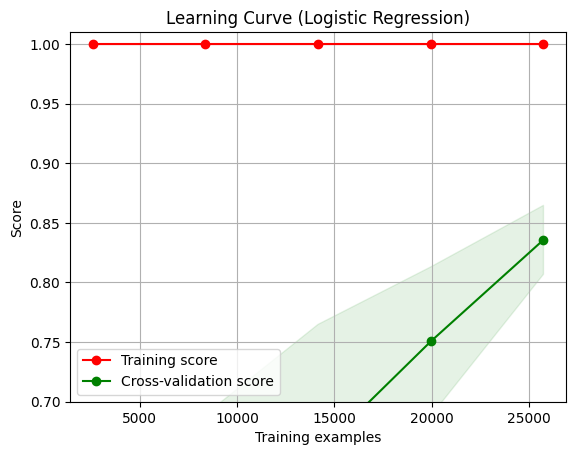

In [47]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An instance of the model to be trained.
        
    title : string
        Title for the chart.
        
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
        
    y : array-like, shape (n_samples)
        Target relative to X for classification or regression.
        
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum y-values plotted.
        
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to generate the learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    plt.show()

#random forest
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()

plot_learning_curve(rf_classifier, "Learning Curve (Logistic Regression)", x_train, y_train, ylim=(0.7, 1.01), cv=5, n_jobs=4)

# 6. Model Evaluation

In [ ]:
# evaluate with test set
y_pred = logreg_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.5585
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       581
           1       0.76      0.56      0.64       695
           2       0.30      0.53      0.39       159
           3       0.48      0.48      0.48       275
           4       0.44      0.54      0.48       224
           5       0.22      0.65      0.33        66

    accuracy                           0.56      2000
   macro avg       0.49      0.56      0.50      2000
weighted avg       0.63      0.56      0.58      2000

[[351  50  43  44  55  38]
 [ 55 386  98  55  53  48]
 [  9  25  84  14  17  10]
 [ 36  26  29 132  24  28]
 [ 17  17  17  26 121  26]
 [  3   4   6   5   5  43]]


In [ ]:
y_pred = mnb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.853
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       581
           1       0.86      0.91      0.88       695
           2       0.74      0.65      0.69       159
           3       0.88      0.77      0.82       275
           4       0.89      0.79      0.83       224
           5       0.76      0.59      0.67        66

    accuracy                           0.85      2000
   macro avg       0.83      0.77      0.80      2000
weighted avg       0.85      0.85      0.85      2000

[[542  15   1  13   9   1]
 [ 15 633  35   3   4   5]
 [ 11  40 104   4   0   0]
 [ 29  29   1 211   5   0]
 [ 23  11   0   7 177   6]
 [  9  12   0   1   5  39]]


In [ ]:
y_pred = svm_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.571
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       581
           1       0.76      0.57      0.65       695
           2       0.32      0.54      0.40       159
           3       0.50      0.49      0.49       275
           4       0.45      0.55      0.49       224
           5       0.23      0.62      0.33        66

    accuracy                           0.57      2000
   macro avg       0.50      0.57      0.51      2000
weighted avg       0.63      0.57      0.59      2000

[[361  52  43  41  53  31]
 [ 57 397  94  48  52  47]
 [  8  26  86  13  16  10]
 [ 36  25  27 134  27  26]
 [ 16  19  15  26 123  25]
 [  3   5   7   5   5  41]]


In [ ]:
y_pred = xgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.585
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       581
           1       0.63      0.70      0.67       695
           2       0.39      0.33      0.36       159
           3       0.54      0.41      0.47       275
           4       0.47      0.43      0.45       224
           5       0.41      0.44      0.43        66

    accuracy                           0.58      2000
   macro avg       0.51      0.50      0.50      2000
weighted avg       0.58      0.58      0.58      2000

[[389 107  14  26  39   6]
 [ 88 489  39  37  29  13]
 [ 22  57  52  13  10   5]
 [ 58  53  15 114  27   8]
 [ 39  55   7  17  97   9]
 [  7  14   6   4   6  29]]


In [ ]:
y_pred = lgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.596
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       581
           1       0.65      0.71      0.68       695
           2       0.41      0.40      0.41       159
           3       0.51      0.42      0.46       275
           4       0.48      0.48      0.48       224
           5       0.42      0.45      0.43        66

    accuracy                           0.60      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.59      0.60      0.59      2000

[[383  93  21  37  41   6]
 [ 78 492  40  37  35  13]
 [ 19  45  64  15  12   4]
 [ 48  61  16 116  25   9]
 [ 27  50  10  20 107  10]
 [ 11  13   5   4   3  30]]


In [ ]:
y_pred = adaboost_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.4825
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       581
           1       0.63      0.55      0.59       695
           2       0.25      0.47      0.33       159
           3       0.46      0.37      0.41       275
           4       0.33      0.44      0.38       224
           5       0.20      0.47      0.28        66

    accuracy                           0.48      2000
   macro avg       0.42      0.46      0.42      2000
weighted avg       0.54      0.48      0.50      2000

[[278  98  57  44  70  34]
 [ 68 380  94  44  66  43]
 [  9  35  75  14  18   8]
 [ 30  40  38 103  38  26]
 [ 30  38  23  19  98  16]
 [  9   9   8   2   7  31]]
